# easy OCR을 활용한 번호판 인식

## 1. 라이브러리 호출

In [1]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt

## 2. 이미지 불러오기

Height: 1080, Width: 1440, Channel: 3


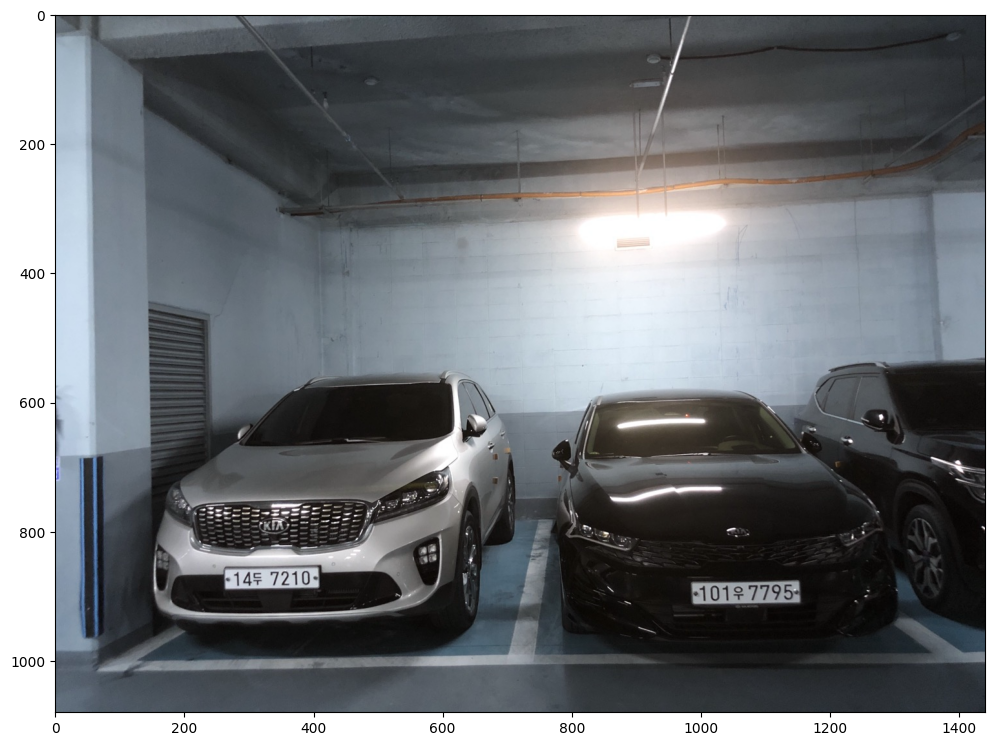

In [104]:
src_img = cv2.imread("./data/car_number_practice2.jpeg")
img = src_img.copy()

height, width, channel = img.shape
plt.figure(figsize=(12,10))
plt.imshow(img, cmap='gray')
print(f'Height: {height}, Width: {width}, Channel: {channel}')

## 3. 흑백이미지 변환

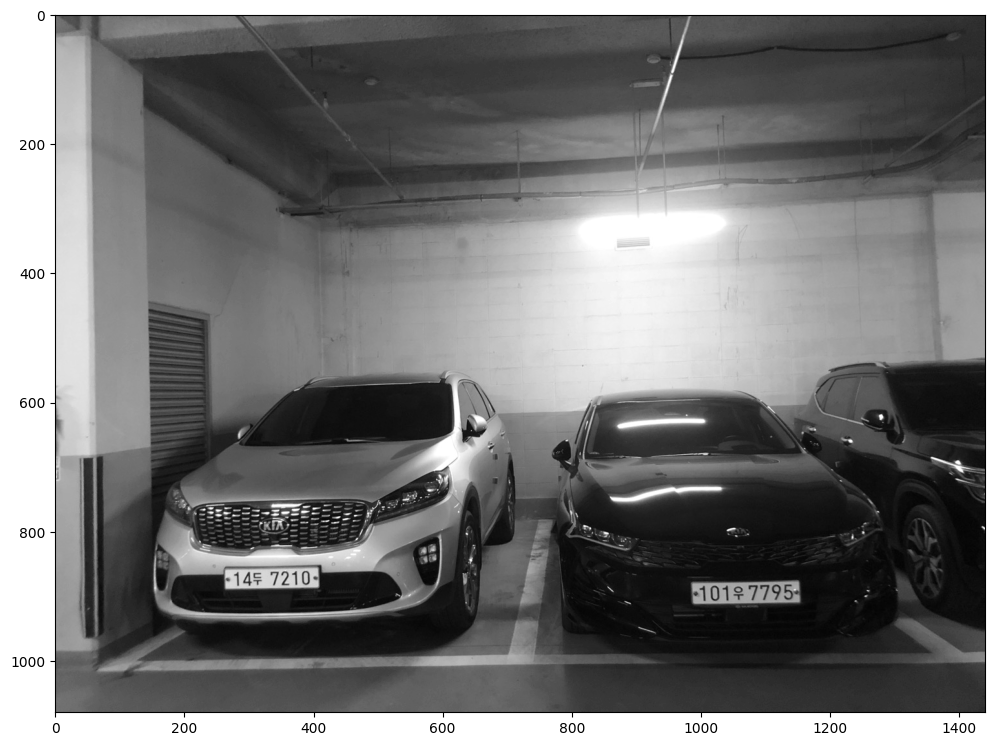

In [105]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

## 4. Adaptive Thresholding(임계처리)

In [106]:
# 가우시안 블러 사용해서 노이즈 제거
img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

In [107]:
# 가우시안 블러 사용 X
img_thresh = cv2.adaptiveThreshold(
    gray, 
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

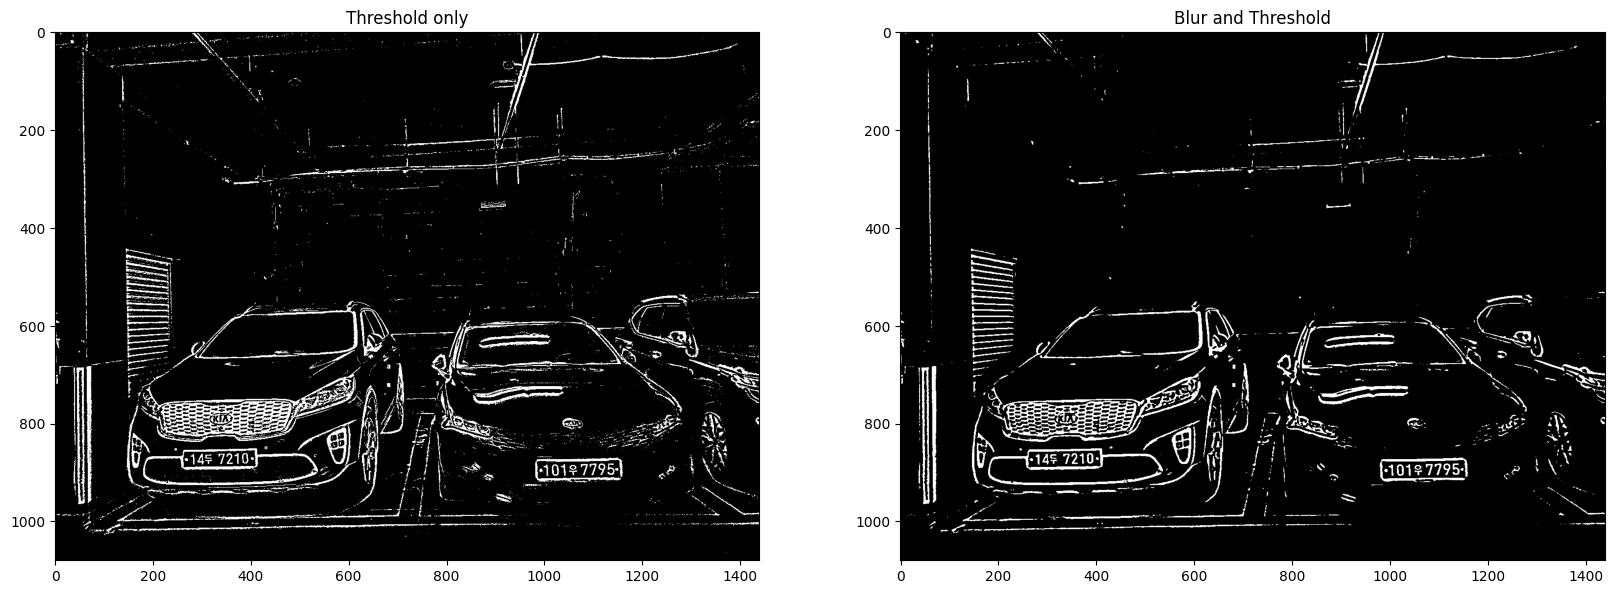

In [108]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Threshold only')
plt.imshow(img_thresh, cmap='gray')

plt.subplot(1,2,2)
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh, cmap='gray')

## 5. 경계선 검출(Find Contours)
> 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선

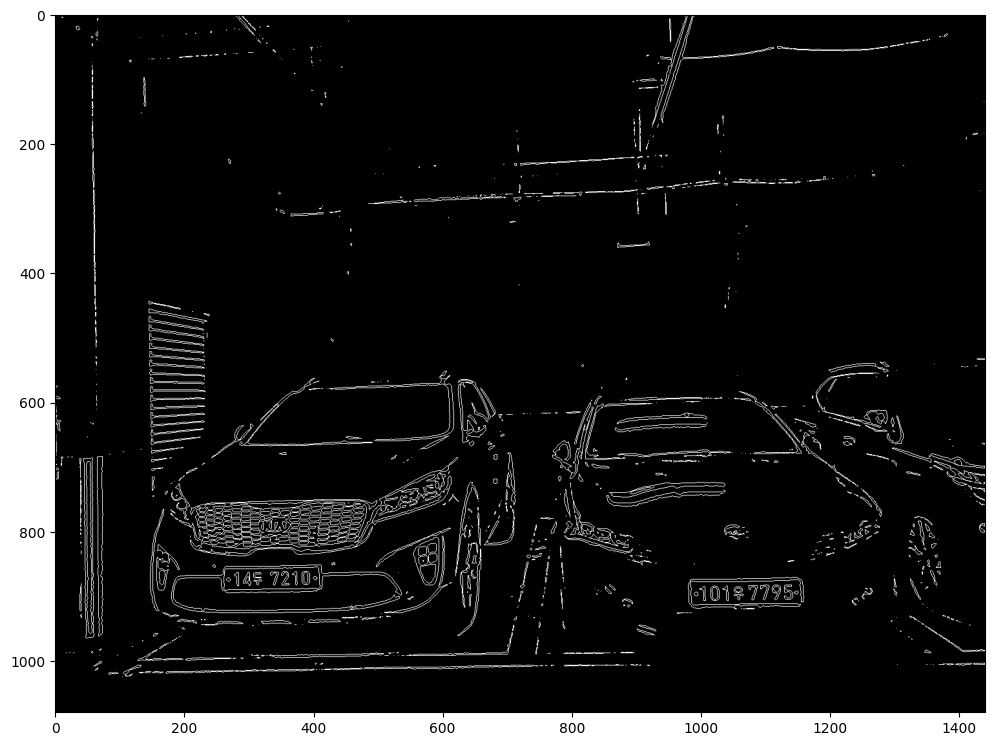

In [109]:
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height,width,channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12,10))
plt.imshow(temp_result)

## 6. 데이터 준비(확인)
> 사각형 영역 그려보기


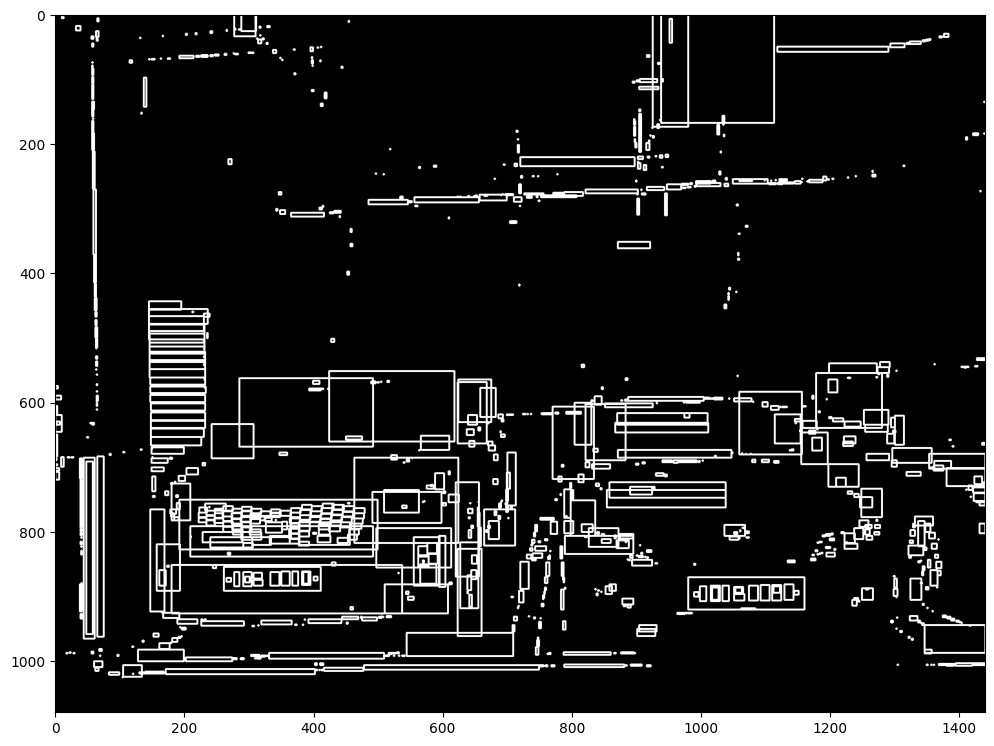

In [110]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2) #점찍고 직사각형 그리기

    contours_dict.append({
        'contour':contour,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x+(w/2),
        'cy':y+(h/2)
    })

plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

## 7. Select Candidates by Char Size
- 번호판 글자인것 같은 Contours 추려내기
- 번호판 일정한 사이즈!

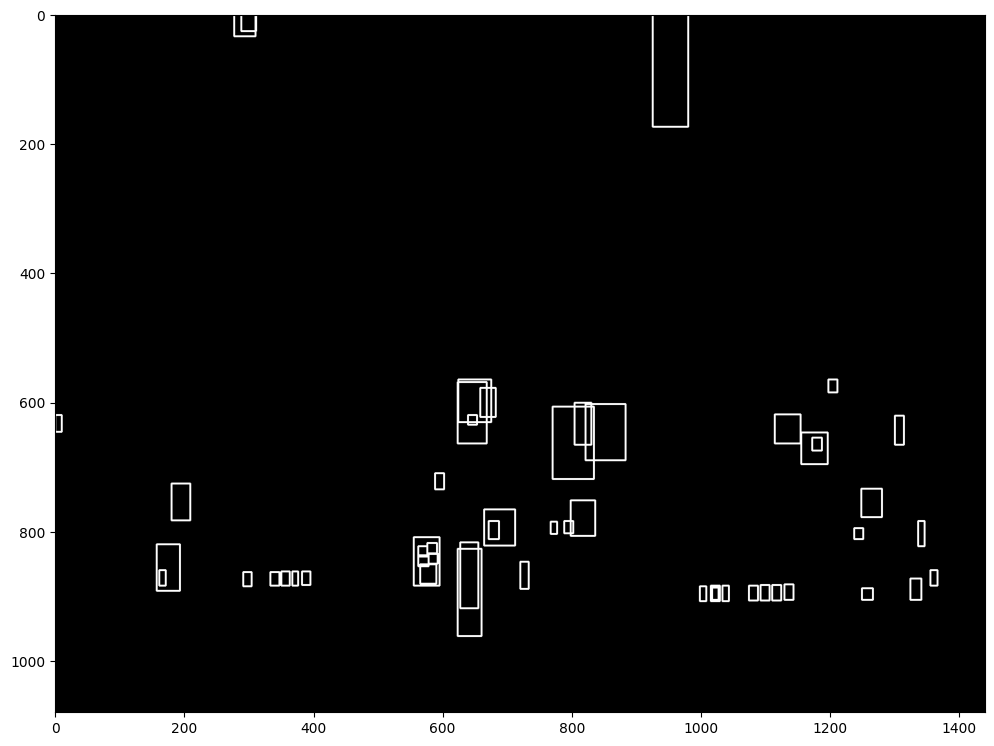

In [111]:
MIN_AREA = 180
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height,width,channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'],d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

## 8. Select Candidates by Arrangement of Contours
- 추려낸 경계선 중, 확실하게 번호판을 찾기 위해 기준을 강화

1. 번호판 Contours의 width와 height의 비율은 모두 동일하거나 비슷하다.
2. 번호판 Contours 사이의 간격은 일정하다.
3. 최소 3개 이상 Contours가 인접해 있어야 한다.(대한민국 번호판 기준)

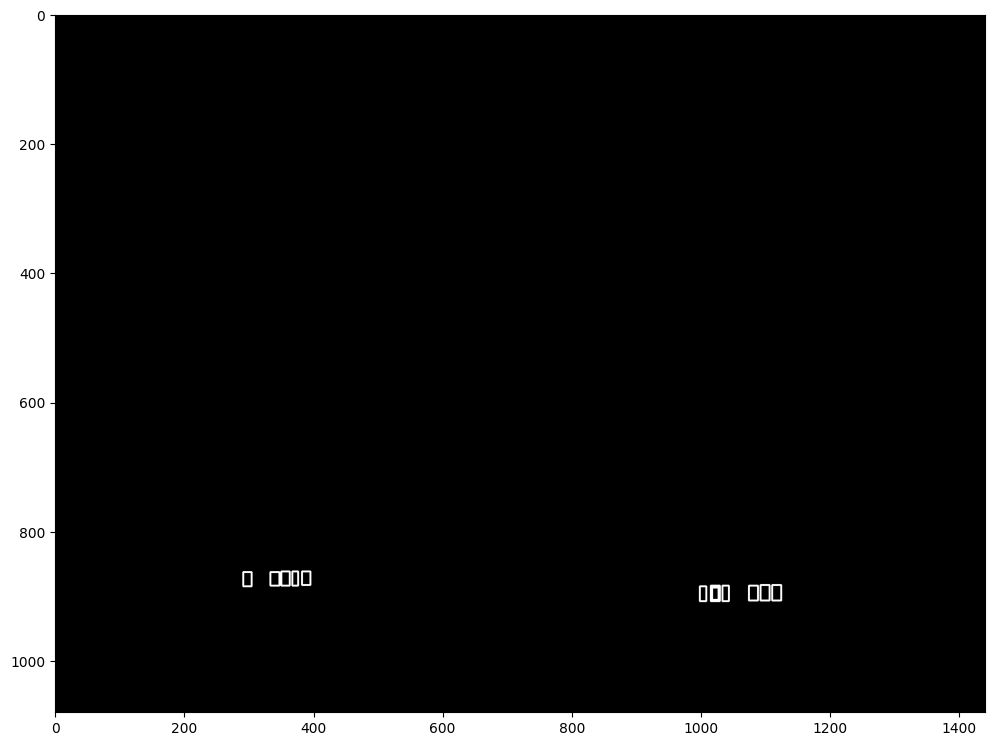

In [112]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 4

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## 9. Rotate Plate Images
- 기울어진 번호판 정방향으로 만들기

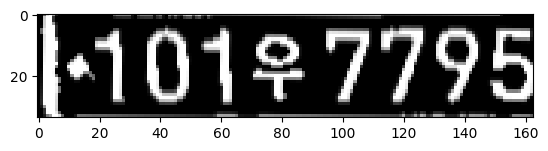

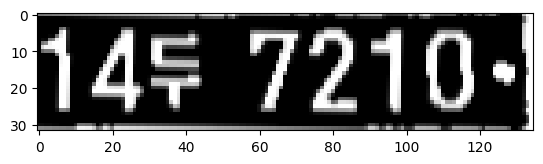

In [114]:
PLATE_WIDTH_PADDING = 1.3  # 1.3
PLATE_HEIGHT_PADDING = 1.5  # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )

    if img_cropped.shape[1] and img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] and img_cropped.shape[
        0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i + 1)
    plt.imshow(img_cropped, cmap='gray')
    plt.show()
    
    cv2.imwrite('car_number_cropped.png', img_cropped)

## 10.Easy OCR 검출
- pip install easyocr
- Error:module 'PIL.Image' has no attribute 'ANTIALIAS'
- 해결: pip install --force-reinstall -v "Pillow==9.5.0"

In [115]:
import easyocr
import os

reader = easyocr.Reader(['en', 'ko'], gpu=False)

result = reader.readtext("car_number_cropped.png")
# readtext() 안에서 detail = 0 이라는 옵션 줄 경우, 결과만 나옴
# 안쓰면, 좌표 - 결과 - 정확도 까지 출력해줌
# allowlist="0,1,2,3,4,5,6,7,8,9" 옵션 활용하면 해당 숫자들만 검출 가능함
print(result)

Using CPU. Note: This module is much faster with a GPU.


[([[0, 0], [135, 0], [135, 32], [0, 32]], '14두 7210;', 0.4611670271732303)]
